<a href="https://colab.research.google.com/github/ron-levi/my_projects/blob/master/NER_models_final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PROPOSAL ###

**Using Named Entity Recognition techniques to extract attributes from E-Commerce products data**

Students:
Maxim Segal, id: 317026557
Ron Levi, id: 200541456


**Goal**

We want to address a problem that is very important and prevalent in different domains of eCommerce: extracting products' attributes and their values from plain textual data.


**Motivation**

Quality extraction of products' attributes and having them saved in a structured manner can significantly improve search results in eCommerce retail system, enrich products catalog and improve the overall customer experience. 

Any eCommerce player, big as small, seeks to accurately predict and answer the customers' demand for products. This may lead to ways of enriching the offered catalogs.

Also, in the today's competitive world between eccomerce players, by precisely satisfying the demand for goods to the customers - the overall well-being of the economy increases.

Subsequently, we would like to address the above by building a tool that merges several existing state-of-the-art approaches in the field of Named Entity Recognition and tailor a solution for this specific task. 
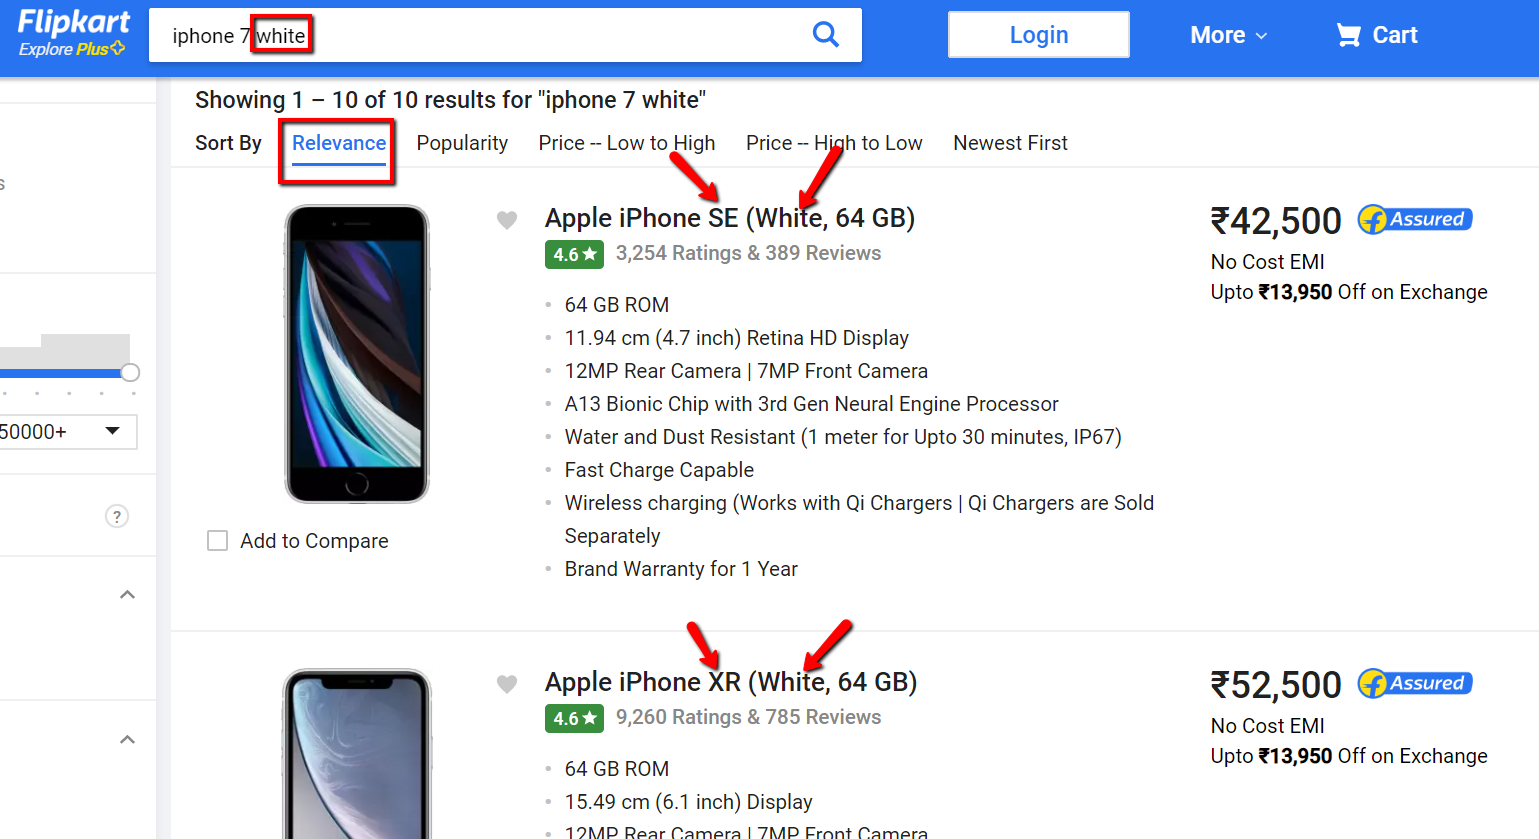


In the above image we can see that customer query is not met appropriatly. We searched for a white iphone 7 but the results show that the phone model was not recognized from user's query. We aim to recognize the model of the product (in this case- 7) which will assist with search results optimization. 

**Proposed Solutions**

We want to try achieving viable, quality solution to product attributes extraction: 

given a plain text descriptions and/or other (unstructured) specifications we aim to extract the needed data in (attribute:value) pairs. As said, it can be utilized for search optimization and also helping decision makers to attain a better understanding of their catalog and make informed buisness decisions. Our pipeline will be as follows:
![picture](https://www.nltk.org/images/ie-architecture.png)

**Datasets**

Initially, for the purpose of this POC and due to products dataset currently unavailable, we will demonstrate several NER approaches in conceptually similar tasks. We will use alternative datasets just to present these techniques. The datasets are:
- **CoNLL 2002**:
Spanish annotated dataset from NLTK for extracting person/organization/location/misc named entities from spanish corpora. This dataset is composed of list of sentences where each sentence is structured in the standard representation scheme of IOB tags, a tuple in following order: (the token, its Part Of Speach tag, its entity label).
Lets see how the annotated sentences data actually look like:


In [ ]:
import nltk
nltk.download('conll2002') # dataset

train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
print('This is an example of an annotated sentence: \n')
train_sents[5]


This is an example of an annotated sentence: 



[('Por', 'SP', 'O'),
 ('su', 'DP', 'O'),
 ('parte', 'NC', 'O'),
 (',', 'Fc', 'O'),
 ('el', 'DA', 'O'),
 ('Abogado', 'NC', 'B-PER'),
 ('General', 'AQ', 'I-PER'),
 ('de', 'SP', 'O'),
 ('Victoria', 'NC', 'B-LOC'),
 (',', 'Fc', 'O'),
 ('Rob', 'NC', 'B-PER'),
 ('Hulls', 'AQ', 'I-PER'),
 (',', 'Fc', 'O'),
 ('indicó', 'VMI', 'O'),
 ('que', 'CS', 'O'),
 ('no', 'RN', 'O'),
 ('hay', 'VAI', 'O'),
 ('nadie', 'PI', 'O'),
 ('que', 'PR', 'O'),
 ('controle', 'VMS', 'O'),
 ('que', 'CS', 'O'),
 ('las', 'DA', 'O'),
 ('informaciones', 'NC', 'O'),
 ('contenidas', 'AQ', 'O'),
 ('en', 'SP', 'O'),
 ('CrimeNet', 'NC', 'B-MISC'),
 ('son', 'VSI', 'O'),
 ('veraces', 'AQ', 'O'),
 ('.', 'Fp', 'O')]

- **CoNLL 2003**: 

The CoNLL-2003 is an English named entity dataset that includes 17 label types and is originated from a shared task of annotating the Reuters Corpus. Its layout is similar to the previously described CoNLL 2002 dataset with an added column specifying the indices of each sentence. Here we show words distribution across the dataset and the tabular display of a single sentence:

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['I-eve', 'B-gpe', 'I-art', 'I-nat', 'I-per', 'B-org', 'B-per', 'I-gpe', 'B-geo', 'I-tim', 'B-nat', 'B-art', 'I-geo', 'O', 'I-org', 'B-eve', 'B-tim']
Number of Labels:  17


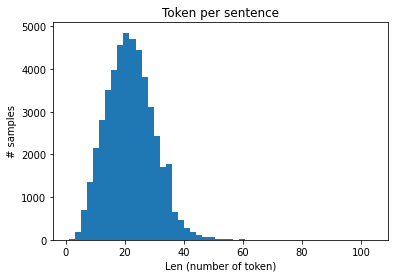

What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
# ! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite
import tensorflow as tf
import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# After hyperparams optimization
BATCH_SIZE = 512  # Number of examples used in each iteration
EPOCHS = 5  # Number of passes through entire dataset
MAX_LEN = 80  # Max length of review (in words)
EMBEDDING = 40  # Dimension of word embedding vector

data = pd.read_csv(os.path.join(path, 'ner_dataset.csv'), encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
   
getter = SentenceGetter(data)
# Get all the sentences
sentences = getter.sentences

# Plot sentence by length
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

print("What the dataset looks like: ")
# Show the first 10 rows
data.head(24)

**Algorithms and Frameworks**

Our research included multiple machine learning classifiers including CRF and RNNs combined with CRF. 
We will employ deep learning methods from Tensorflow, Keras, spaCy along with traditional machine learning algorithms from scikit-learn and sklearn-crfsuite for entities recognition in the products attributes extraction context.


**Proof Of Concept**

We want to show two approaches to solve our problem:
  1. Conditional random fields (CRF) - a class of discriminative models suited to prediction tasks such as ours, where contextual information or state of the neighbors affect the current prediction. 
  2. Bi-directional LSTM-CRF model - a neural network that benefits from word and character level information and dependencies across adjacent labels which is also useful for textual data.  

**Conditional random fields (CRF):**

In this example we show a usage of CRF classifier on the person-organization-location dataset.
We first preprocess our data by assigning features to each of the tokens of the sentences and provide the information in that form to the CRF model

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('conll2002') # dataset

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]    

!pip install sklearn_crfsuite
# employ crf model
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
def crf_pipeline(X_train, y_train, X_test, y_test):
  crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=200, all_possible_transitions=True)
  crf.fit(X_train, y_train)
  labels = list(crf.classes_)
  y_pred = crf.predict(X_test)
  print(metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels))
  print(metrics.flat_classification_report(y_test, y_pred, labels=labels, digits=3))

crf_pipeline(X_train, y_train, X_test, y_test)  


0.9713896997078182
              precision    recall  f1-score   support

       B-LOC      0.813     0.787     0.800      1084
           O      0.993     0.997     0.995     45355
       B-ORG      0.813     0.834     0.823      1400
       B-PER      0.844     0.888     0.865       735
       I-PER      0.878     0.940     0.908       634
      B-MISC      0.717     0.560     0.629       339
       I-ORG      0.860     0.789     0.823      1104
       I-LOC      0.697     0.643     0.669       325
      I-MISC      0.725     0.621     0.669       557

    accuracy                          0.972     51533
   macro avg      0.815     0.784     0.798     51533
weighted avg      0.971     0.972     0.971     51533




We can see that the scores are reasonable, although we may change our  algorithms if we will discover it is not suitable for the nature of our problem. 








**Bi-directional LSTM-CRF model**

In this approach, we use words embeddings made from the textual data and feed it to a neural net with bidirectional Conditional Random Field layer.

---



In [ ]:

######## preprocessing ##########
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["PAD"] = 0 # Padding
word2idx["UNK"] = 1 # Unknown words
idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: t for t, i in tag2idx.items()}

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

########### Bidirectional-LSTM-CRF model ############

! pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

# Model training 
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=2)

# Evalualtion
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

!pip install sklearn_crfsuite
from sklearn_crfsuite.metrics import flat_classification_report
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 80, 40)            1407200   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 80, 100)           36400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 80, 50)            5050      
_________________________________________________________________
crf_3 (CRF)                  (None, 80, 18)            1278      
Total params: 1,449,928
Trainable params: 1,449,928
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
 - 79s - loss: 0.5408 - crf_viterbi_accuracy: 0.8720 - val_loss: 0.2221 - val_crf_viterbi_accuracy: 0.9527
Epoch 2/5
 - 77s - loss: 0.1792 - crf_viterbi_accuracy: 0.9577 - val_loss: 0.1240 - val_crf_viterbi_accuracy: 0.9620
Epoch 3/5
 - 77s - loss: 0.0962 - crf_viterbi_accuracy: 0.9692 - val_loss: 0.0797 - val_crf_viterbi_accuracy: 0.9745
Epoch 4/5
 - 78s - loss: 0.0624 - crf_viterbi_accuracy: 0.9812 - val_loss: 0.0522 - val_crf_viterbi_accuracy: 0.9843
Epoch 5/5
 - 79s - loss: 0.0401 - crf_viterbi_accuracy: 0.9871 - val_loss: 0.0360 - val_crf_viterbi_accuracy: 0.9872


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        31
       B-eve       0.00      0.00      0.00        25
       B-geo       0.78      0.88      0.83      3700
       B-gpe       0.94      0.85      0.90      1555
       B-nat       0.00      0.00      0.00        28
       B-org       0.71      0.57      0.63      1969
       B-per       0.85      0.67      0.75      1747
       B-tim       0.90      0.76      0.82      2053
       I-art       0.00      0.00      0.00        20
       I-eve       0.00      0.00      0.00        18
       I-geo       0.77      0.68      0.72       750
       I-gpe       0.00      0.00      0.00        19
       I-nat       0.00      0.00      0.00         4
       I-org       0.72      0.63      0.67      1599
       I-per       0.83      0.81      0.82      1801
       I-tim       0.93      0.34      0.50       615
           O       0.98      1.00      0.99     87985
         PAD       1.00    

Even though the Bi-LSTM-CRF results on the CoNLL 2003 are dubious, according to the literature the scores are usually higher and we will understand how to achieve better results going forward.

**Reporting**

In our task we want to consider the F1 score while giving emphasis on precision.
We want to build our data set from an exisiting production eCommerce database. Currently we have tagged products data with several attributes and need to translate it to the needed format (token, POS, attribute label). After that we want to experiment with the mentioned and other models in an attempt to reach the highest possible scores. 

We would like to achieve a model in which the classifying labeling will run automatically preferably without expert human tagging.




**Summary**

Eventually we want to build and present the training, test and validation datasets that will consist of real online products unstructured data (i.e. description, names and specifications).

Out of the presented algoritms, for a similar task to ours, CRF currently seems to be able to achieve best results in terms of recall and precision. But nethertheless we want to adjust Bi-LSTM-CRF to our datasets and try to explore and combine other advanced techniques to improve quality of attributes labeling in terms of suitable conventional scoring metrics.



In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive = drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


################################################################################

### DATA EXPLANATION AND DISPLAY ###
In an effort to construct the real-world data for our needs we worked extensively with real data of our company (Flipkart). We ran and adjusted multiple reports against multiple databases in order to achieve labeled data of 7130 products:
Finally, the final result was train data with 2 main columns: 

1.   product name - holds the documents from which the attributes words will need to be tagged in.
2.   attrs_indexes_dict - holds a dictionary in which keys are the attribute names and the values are the start and end indexes of the entities recognized in the sentences.


this is the first 10 rows of the data:


In [ ]:
import pandas as pd
import os

df=pd.read_csv('/content/drive/My Drive/Colab/Data sets/all_cms_indexed.csv',usecols=['product_name','attrs_indexes_dict'], encoding="utf-8")
pd.set_option('display.max_colwidth', -1)
df.head(10)

,product_name,attrs_indexes_dict
0,HP 290-P0012in Desktop 7th Gen PDC G4560 4GB 1TB Win 10 MSO Wired Keyboard and Mouse One Year Warranty,"{u'system_memory': (41, 44)}"
1,HP 20-c029in AIO Desktop,{}
2,"Lenovo Ideacentre 310S-08IGM 90HX0006IN Tower PC (J5005/4GB/1TB/DOS/Integrated Graphics), Silver -- desktop","{u'color': (90, 96), u'system_memory': (56, 59), u'operating_system': (64, 67)}"
3,Lenovo V520 Slim Tower(10NNA01SHF) Gen 7 B250/ i3-7100 3.9G 2C/4GB DDR4 2400/1TB/ ODD/Win 10 HSL/No Wifi+BT/ 85%Efficiency/19.5Monitor,"{u'processor_name': (47, 49), u'system_memory': (63, 66)}"
4,"Lenovo Ideacentre 310S 90HX004MIN Desktop (Celeron J4005/4GB/1TB HDD/DOS/Integrated Graphics), Silver","{u'color': (95, 101), u'processor_name': (43, 50), u'system_memory': (57, 60), u'operating_system': (69, 72)}"
5,"HP S01 Slim SO1-pF0111il Desktop (9th Gen i5 9400/8GB/1TB/DOS/Integrated Graphics), Jet Black","{u'color': (88, 93), u'processor_name': (42, 44), u'system_memory': (50, 53), u'operating_system': (58, 61)}"
6,LENOVO V520 Tower 10NLA011IH Gen7 B250/ i5-7400 3.0G 4C/ 4GB DDR4 2400/ 1TB/ No ODD and OS/ 19.5Monitor/ Internal Speaker,"{u'processor_name': (40, 42), u'system_memory': (57, 60)}"
7,ASUS Desktop (Pentium/4GB/1TB/Win 10) + 19 inch Monitor -- desktop + monitor combo,"{u'system_memory': (22, 25)}"
8,HITSAN 3IN1 Din Rail LED Display Voltage Current Frequency Meter 80-300V 200-450V 0-100A Voltmeter Ammeter Three in one with Extra CT Color 80 to 300V,{}
9,diymore 3 in 1 Fuse Power Supply Socket Top Quality Three in one Socket for 3D Printer Accessory/Parts,"{u'features': (76, 78)}"


The above dataframe is then converted to tab delimited txt file consisting of <token, IOB> pairs (Inside and Begining labels) in the following format:



> HP	O <br>
15	O <br>
Intel	B-processor_brand <br>
Celeron	B-processor_name <br>
Dual	I-processor_name <br>
Core	I-processor_name <br>
15	O <br>
6-Inch	O <br>
HD	B-type <br>
Laptop	O <br>
4	B-system_memory <br>
GB	I-system_memory <br>
1	B-ssd_capacity <br>
TB	I-ssd_capacity <br>
Windows	B-operating_system <br>
10	O <br>
Integrate	O <br>
Graphics	O <br>
Black	B-color <br>
1	O <br>
77	O <br>
Kg	O <br>
15-da0099tu	O <br>









In [ ]:
import itertools
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append("../src")
# from utils import *
from collections import Counter
import gc
import random

from itertools import groupby
from itertools import chain
sns.set(rc={'figure.figsize': (15, 12)})
from gensim.models import KeyedVectors, Word2Vec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score, plot_confusion_matrix
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
from textblob import Word
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


def get_sentese_tag_lists(filename):
    lines = []
    with open(filename, encoding='utf-8') as fp:
        for line in fp:
            lines.append(line)
    
    sentences = (list(g) for k, g in groupby(lines, key=lambda x: x != '\n') if k)
    list_of_lists_of_tags = []
    list_of_lists_of_tokens = []
    for sentence in sentences:
        tags_in_sentence = []
        tokens_in_sentence = []
        for tag_and_token in sentence:
            tag, token = tag_and_token.split('\t')
            if '\n' not in token:
                raise
            token = token.replace('\n', '')
            tags_in_sentence.append(tag)
            tokens_in_sentence.append(token)
        list_of_lists_of_tags.append(tags_in_sentence)
        list_of_lists_of_tokens.append(tokens_in_sentence)
    tags_tokens_tuple_list = []
    for tags_in_sentence, tokens_in_sentence in zip(list_of_lists_of_tags, list_of_lists_of_tokens):
        tags_tokens_tuple_list.append(list(zip(tags_in_sentence, tokens_in_sentence)))
    return tags_tokens_tuple_list


def get_token_tags(sentences):
    list_of_tokens_lists = []
    list_of_tags_lists = []
    for sentence in sentences:
        tokens_list, tags_list = [], []
        for tag, token in sentence:
            tags_list.append(tag)
            tokens_list.append(token)
        list_of_tokens_lists.append(tokens_list)
        list_of_tags_lists.append(tags_list)
    return list_of_tags_lists, list_of_tokens_lists

train_filepath = '/content/drive/My Drive/Colab/Data sets/train_set_all_cms.txt'
test_filepath = '/content/drive/My Drive/Colab/Data sets/test_set_all_cms.txt'

train_data_generator = list(get_sentese_tag_lists(train_filepath))
test_data_generator = list(get_sentese_tag_lists(test_filepath))

train_tags, train_tokens = get_token_tags(train_data_generator)
test_tags, test_tokens = get_token_tags(test_data_generator)

Above code transforms the txt file records to documents where each consists of token, tag pairs as follows:

In [ ]:
train_data_generator[22]

[('O', 'ASUS'),
 ('O', 'ZenBook'),
 ('O', '14'),
 ('O', 'UX433FA-A6111R'),
 ('B-processor_brand', 'Intel'),
 ('B-processor_name', 'Core'),
 ('I-processor_name', 'i7'),
 ('B-processor_generation', '8th'),
 ('I-processor_generation', 'Gen'),
 ('O', '14-inch'),
 ('O', 'FHD'),
 ('O', 'Thin'),
 ('O', 'and'),
 ('O', 'Light'),
 ('O', 'Laptop'),
 ('B-system_memory', '8GB'),
 ('O', 'RAM'),
 ('O', '512GB'),
 ('O', 'NVMe'),
 ('B-type', 'SSD'),
 ('B-operating_system', 'Windows'),
 ('O', '10'),
 ('O', 'Professional'),
 ('O', 'Integrated'),
 ('O', 'Graphics'),
 ('O', '1'),
 ('O', '19'),
 ('O', 'kg'),
 ('O', 'Icicle'),
 ('B-color', 'Silver')]

### EXPLORATORY ANALYSIS ###


Let's explore our data. We will start with distribution of sentnences lenghts:

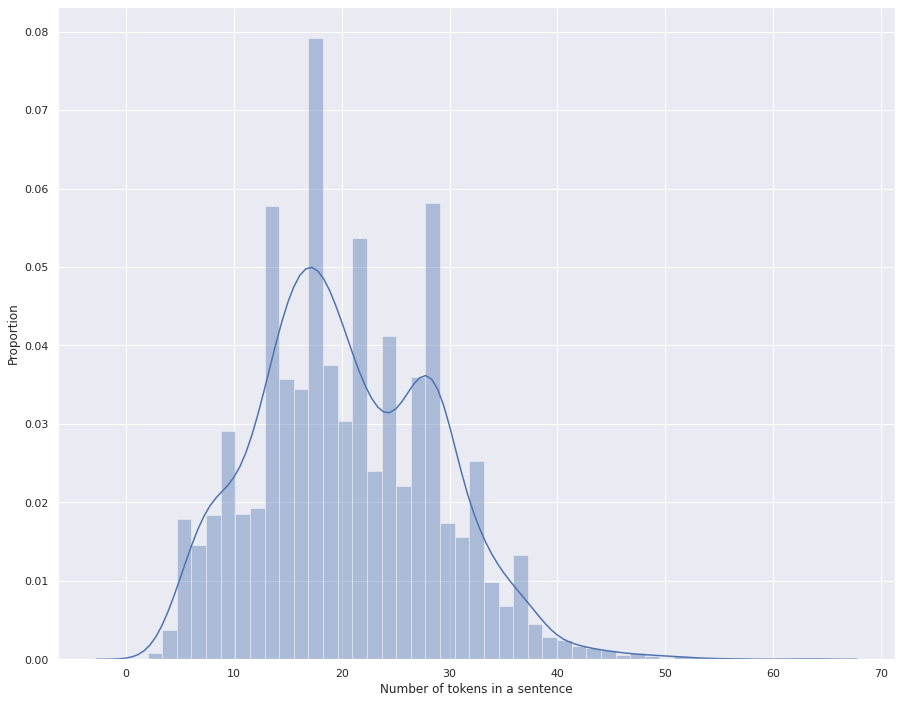

Median:  20.0
Average:  20.56


In [ ]:
# Sentence length distribution
lengths = list(map(lambda x: len(x), train_data_generator))
sns.distplot(lengths)
plt.xlabel("Number of tokens in a sentence")
plt.ylabel("Proportion")
plt.show()
print("Median: ", np.median(lengths))
print("Average: ", round(np.mean(lengths), 2))

We got a median/average legnth of ~20 tokens per sentence. There only a few outliers that does not affect the distribution significantly.


Percentage of total Tokens/Tags:

Number of unique items:  40
Average count:  2749 



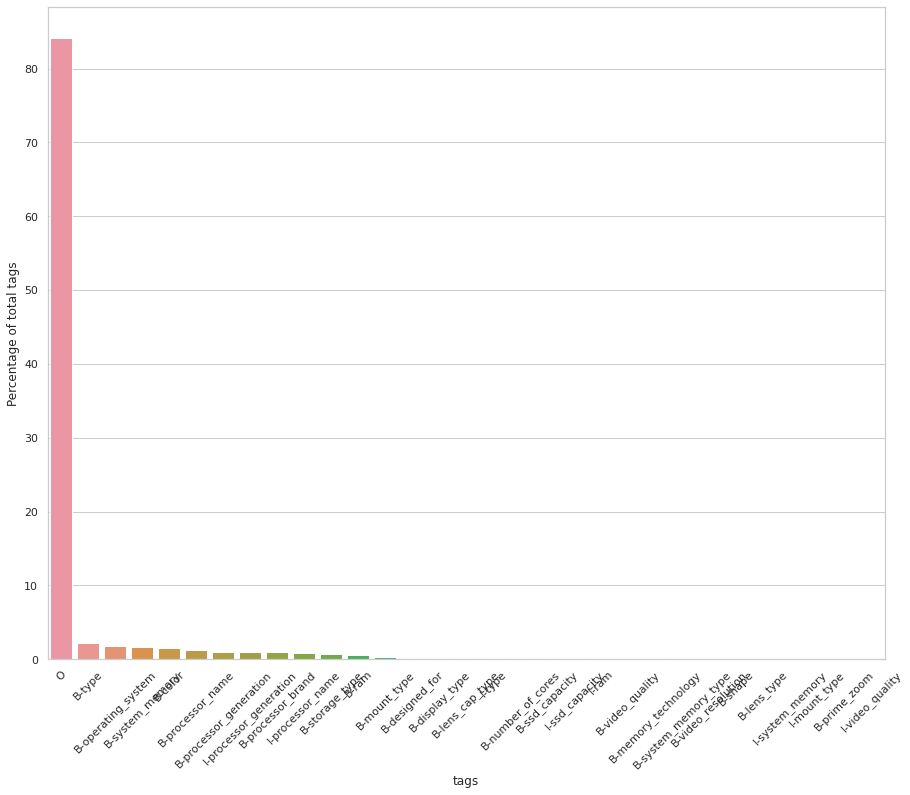

In [ ]:
def summary(item_list, tokens_or_tags, limit=30):  
    flat_list = list(itertools.chain.from_iterable(item_list))
    count_dict = dict(Counter(flat_list))
    count_items = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    print("Number of unique items: ", len(count_items))
    print("Average count: ", round(len(flat_list) / len(count_items)), "\n")
    total_items = len(flat_list)
    proportion_list = []
    xlabels = []
    for i, (key, value) in enumerate(count_items):
        if limit:
            if i > limit:
                break
        proportion = round(value * 100 / total_items, 2)
        proportion_list.append(proportion)
        xlabels.append(key)
        # print(key, " ---> ", proportion, "%")
    sns.set(style="whitegrid")
    chart = sns.barplot(xlabels, proportion_list, orient="v")
    plt.xlabel(tokens_or_tags)
    plt.ylabel("Percentage of total "+tokens_or_tags)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    plt.show()


summary(train_tags,'tags')




Not surprisingly the "O" tag has a predominant share in comparison to others. This makes sense because the relevant product attributes are found scarsely within product names. The rest of the tags have expected low frequency distribution. Here we can see the actual percentage of each label among the sentences:



In [ ]:
# Number of Beginnings vs Inside Tags
flat_list = list(itertools.chain.from_iterable(train_tags))

tags_counts = dict(Counter(flat_list))
beginning = 0
intermediate = 0
none = 0
for key, value in tags_counts.items():
    if key.startswith("B"):
        beginning += value
    elif key.startswith("I"):
        intermediate += value
    else:
        none += value
total = beginning + intermediate + none

print("Beginning tags proportion (B-) -> ", round(beginning * 100 / total, 2), "%")
print("Intermediate (I-) tags proportion -> ", round(intermediate * 100 / total, 2), "%")
print("None (O) tags proportion -> ", round(none * 100 / total, 2), "%")

train_datasize = len(list(train_data_generator))
flat_train_tokens_list = list(itertools.chain.from_iterable(train_tokens))
print("Average length of a sentence is: ", round(len(flat_train_tokens_list) / train_datasize, 2))


def tag_presence(token_tag_tuples, tag_to_find):
    for tag, token in token_tag_tuples:
        if tag == tag_to_find:
            return True
    return False


def get_labels_presence(generator, tags, dataset_size):
    flat_list = list(itertools.chain.from_iterable(tags))
    tags_counter = dict(Counter(flat_list))
    tags_counter = sorted(tags_counter.items(), key=lambda x: x[1], reverse=True)

    for key, value in tags_counter:
        if key.startswith("B"):
            sentence_with_tag = len(
                list(filter(lambda token_tag_tuples: tag_presence(token_tag_tuples, key), generator)))
            print("Percentage of sentences having " + key[2:], " are: ",
                  round(sentence_with_tag * 100 / dataset_size, 2), "%")


get_labels_presence(train_data_generator, train_tags, train_datasize)

Beginning tags proportion (B-) ->  13.35 %
Intermediate (I-) tags proportion ->  2.49 %
None (O) tags proportion ->  84.16 %
Average length of a sentence is:  20.56
Percentage of sentences having type  are:  44.56 %
Percentage of sentences having operating_system  are:  36.14 %
Percentage of sentences having system_memory  are:  33.4 %
Percentage of sentences having color  are:  29.81 %
Percentage of sentences having processor_name  are:  26.5 %
Percentage of sentences having processor_generation  are:  21.34 %
Percentage of sentences having processor_brand  are:  20.57 %
Percentage of sentences having storage_type  are:  14.94 %
Percentage of sentences having ram  are:  11.67 %
Percentage of sentences having mount_type  are:  4.66 %
Percentage of sentences having designed_for  are:  4.45 %
Percentage of sentences having display_type  are:  4.04 %
Percentage of sentences having lens_cap_type  are:  3.95 %
Percentage of sentences having number_of_cores  are:  3.48 %
Percentage of senten

Now let's also have a look on how our tokens are distributed

Number of unique items:  7886
Average count:  14 



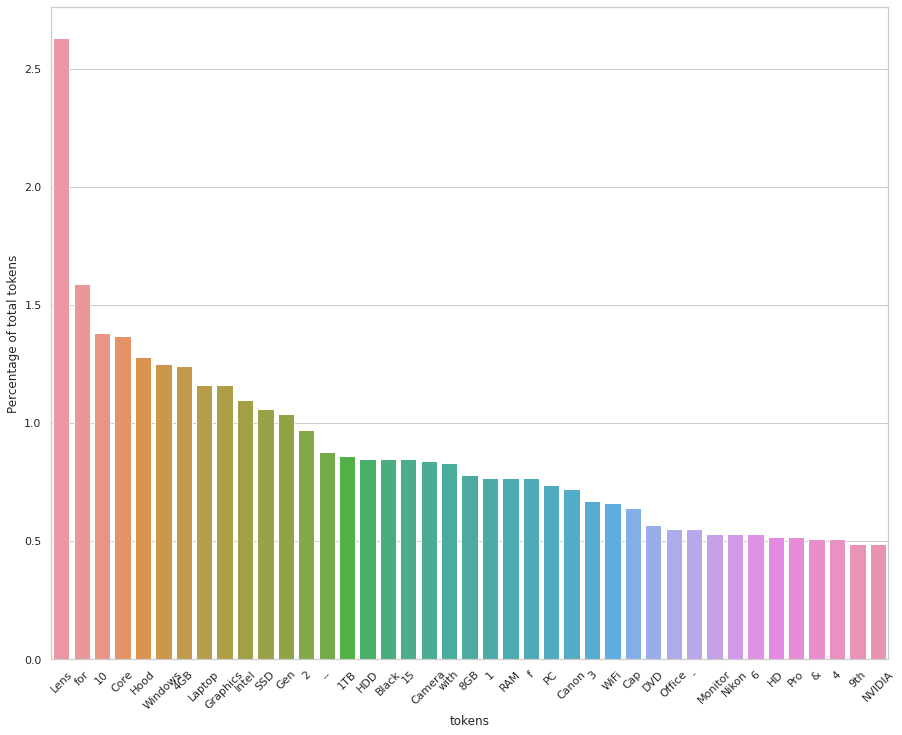

In [ ]:
# Analyzing tokens
summary(train_tokens,"tokens", 40)

As can be expected, the corpus of most frequent words reflects the vocabulary of the Electronics products domain.

### EXPLANATION ABOUT SPACY PIPELINE ###
First approach taken was examining an out-of-the-box, statistical model for named entity recognition from the spaCy package. It's entity recognizer is using an inherent convolutional neural network that's given feedback in the form of an error gradient of the loss function that calculates the difference between the training example and the expected output. 


In [ ]:
### spaCy classifier ###

class SpacyClassifier(object):
    def __init__(self, training_df, output_dir):
        self.output_dir = output_dir
        self.training_df = training_df
        self.full_formatted_data = self.prepare_spacy_input()
        text, labels = zip(*self.full_formatted_data)
        self.text_train, self.text_test, \
        self.labels_train, self.labels_test = train_test_split(text, labels, test_size=0.2, random_state=42)
    
    def prepare_spacy_input(self):
        import ast
        self.training_df = self.training_df[self.training_df['attrs_indexes_dict'] != u'{}']
        input_data = []
        for _, row in self.training_df.iterrows():
            raw_dict = ast.literal_eval(row['attrs_indexes_dict'])
            ent_data = [(raw_dict[key] + (key,)) for key in raw_dict.keys()]
            input_data.append((row['product_name'], {"entities": ent_data}))
        return input_data
    
    def train_spacy(self):
        # Train model
        nlp = English()
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
        for _, annotations in self.full_formatted_data:
            for ent in annotations['entities']:
                ner.add_label(ent[2])
        optimizer = nlp.begin_training()
        for itn in range(10):
            print("Starting iteration # " + str(itn))
            train_set = list(zip(self.text_train, self.labels_train))
            random.shuffle(train_set)
            losses = {}
            batches = minibatch(train_set, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, drop=0.2, sgd=optimizer, losses=losses)
            print("Losses: " + str(losses))
        # Save model
        if self.output_dir is not None:
            output_dir = Path(self.output_dir)
            if not output_dir.exists():
                output_dir.mkdir()
            nlp.meta['name'] = "spaCy ner model"
            nlp.to_disk(output_dir)
            print('Model saved to ', output_dir)
    
    def evaluate_model(self):
        scorer = Scorer()
        nlp = spacy.load(self.output_dir)
        test_set = zip(self.text_test, self.labels_train)
        for text, annot in test_set:
            doc_gold_text = nlp.make_doc(text)
            gold = GoldParse(doc_gold_text, entities=annot['entities'])
            pred_value = nlp(text)
            scorer.score(pred_value, gold)
        return scorer.scores
    
    def evaluate_example(self, test_text):
        nlp = spacy.load(self.output_dir)
        doc = nlp(test_text)
        print("Entities detected in '%s':" % test_text)
        for ent in doc.ents:
            print(ent.label_, ent.text)

path_name = '/content/drive/My Drive/Colab/Data sets'
dataset_df = pd.read_csv(os.path.join(path_name, 'all_cms_indexed.csv'), encoding='utf-8')
model_output_path = '/content/drive/My Drive/Colab/Model output'
spacy_classifier = SpacyClassifier(dataset_df, model_output_path)

In order to use this tool, we make a slight adjustment to our data format and bring it to the spacy needed form: 

In [ ]:
spacy_classifier.full_formatted_data[2]

('Lenovo V520 Slim Tower(10NNA01SHF) Gen 7 B250/ i3-7100 3.9G 2C/4GB DDR4 2400/1TB/ ODD/Win 10 HSL/No Wifi+BT/ 85%Efficiency/19.5Monitor',
 {'entities': [(47, 49, 'processor_name'), (63, 66, 'system_memory')]})

For training we start by adding a 'ner' object to the defualt Spacy language model. We then add all the entity labels to this object and at each iteration, the training data is shuffled to ensure the model doesn’t make any generalizations based on the order of examples. We also use dropout rate parameter to randomly “drop” individual features and representations. This makes it harder for the model to memorize the training data and better predict labels.


In [ ]:
spacy_classifier.train_spacy()
spacy_classifier.evaluate_model()

Starting iteration # 0
Losses: {'ner': 10912.220331768209}
Starting iteration # 1
Losses: {'ner': 6340.305557016691}
Starting iteration # 2
Losses: {'ner': 5094.202148300245}
Starting iteration # 3
Losses: {'ner': 4570.450338589054}
Starting iteration # 4
Losses: {'ner': 4018.546669328896}
Starting iteration # 5
Losses: {'ner': 3805.2509972048124}
Starting iteration # 6
Losses: {'ner': 3480.6551631094203}
Starting iteration # 7
Losses: {'ner': 3066.9711439241996}
Starting iteration # 8
Losses: {'ner': 3009.3998202731254}
Starting iteration # 9
Losses: {'ner': 2848.580823021007}
Model saved to  /content/drive/My Drive/Colab/Model output


{'ents_f': 6.493506493506494,
 'ents_p': 3.8461538461538463,
 'ents_per_type': {'color': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'designed_for': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'display_type': {'f': 66.66666666666666, 'p': 50.0, 'r': 100.0},
  'lens_cap_type': {'f': 15.384615384615383,
   'p': 10.0,
   'r': 33.33333333333333},
  'lens_mount': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'lens_type': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'memory_technology': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'mount_type': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'number_of_cores': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'operating_system': {'f': 15.384615384615383,
   'p': 10.0,
   'r': 33.33333333333333},
  'prime_zoom': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'processor_brand': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'processor_generation': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'processor_name': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'ram': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'shape': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'storage_type': {'f': 0.0, 'p': 0.0, 

### SPACY RESULTS REVIEW ###
As can be seen from results, this "ready" model fails to predict many labels anf generally performs poorly. This was only used as an inital "go to" approach testing. Even following 100 iterations results could not be improved. 

### CRF EXPLANATION ###
As described in the proposal, we wanted to use the CRF model which is a class of discriminative models suited to prediction tasks where contextual information or state of the neighbors affect the current prediction. In our data the tokens, especially those that belong to same entity ("8 GB", "Full HD") are sensitive to their neighbors. Now we run the CRF model on the real-world data:


In [ ]:
import itertools
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import io
import re
import ast
from collections import Counter
! pip install sklearn-crfsuite

class SentenceGetter(object):
    def __init__(self, data):
        self.data = data

    def prepare_input(self):
        output = []
        for ix, row in self.data.iterrows():
            doc = row['product_name']
            att_dict = ast.literal_eval(row['attrs_indexes_dict'])
            sent_words_pos_labels = get_words_pos_labels(doc, att_dict)
            sent_words_pos_iob_labels = get_iob_labels(sent_words_pos_labels)
            output.append(sent_words_pos_iob_labels)
        return output


def get_label(position_to_entity, word_index_in_doc):
    word_start_in_doc, word_end_in_doc = word_index_in_doc
    label = position_to_entity.get(word_index_in_doc, 'O')
    if label != 'O':
        return label
    for (entity_start, entity_end), label_in_attr_dict in position_to_entity.items():
        if entity_start <= word_start_in_doc and entity_end>=word_end_in_doc:
            return label_in_attr_dict
    return label


def get_words_pos_labels(doc, att_dict):
    position_to_entity = {v: k for k, v in att_dict.items()}
    word_delimiter_pattern = re.compile(r"[^,.:;+/()|' ]+")
    words = re.findall(word_delimiter_pattern, doc)
    pos_tags = nltk.pos_tag(words)
    token_indexes = [(i.start(), i.end()) for i in re.finditer(word_delimiter_pattern, doc)]
    words_pos_labels = []
    assert len(pos_tags)   == len(token_indexes)
    for (word, part_of_speech), word_index_in_doc in zip(pos_tags, token_indexes):
        label = get_label(position_to_entity, word_index_in_doc)
        if label in ['battery_type',
                     'compatible_card',
                     'lens_mount',
                     'ports',
                     'features',
                     ]:
            label = 'O'
        words_pos_labels.append((word, part_of_speech, label))
    return words_pos_labels


def get_iob_labels(sent_words_pos_labels):
    words_list, pos_list, labels_list = zip(*sent_words_pos_labels)
    grouped_list = [list(grp) for k, grp in itertools.groupby(labels_list)]
    
    converted_to_iob_list = []
    for group in grouped_list:
        if set(group) == set('O'):
            converted_to_iob_list.extend(group)
        else:
            group = list(map(lambda ix_tuple: decide_iob_prefix(ix_tuple), list(enumerate(group))))
            converted_to_iob_list.extend(group)
    
    assert len(words_list) == len(pos_list) == len(converted_to_iob_list)
    return list(zip(words_list, pos_list, converted_to_iob_list))


def decide_iob_prefix(i_x_tuple):
    i, x = i_x_tuple
    return 'B-{}'.format(x) if i == 0 else 'I-{}'.format(x)

getter = SentenceGetter(dataset_df)
# Get all the sentences
sentences = getter.prepare_input()    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


This part is responsible for preparing the input for the model to be a list of sentences, each in itself represented as a list of tuples of kind: <token, POS tag, IOB label>. POS tags - Part Of Speech labels, representing the grammerly roles of the tokens in sentences as derived of the sentence tree. These make an important feature for labeling entities.

In [ ]:
sentences[22]

[('Lenovo', 'NNP', 'O'),
 ('Ideacentre', 'NNP', 'O'),
 ('310S', 'CD', 'O'),
 ('90HX004KIN', 'CD', 'O'),
 ('Desktop', 'NNP', 'O'),
 ('Celeron', 'NNP', 'B-processor_name'),
 ('J4005', 'NNP', 'O'),
 ('4GB', 'CD', 'B-system_memory'),
 ('1TB', 'CD', 'O'),
 ('HDD', 'NNP', 'O'),
 ('DOS', 'NNP', 'B-operating_system'),
 ('Integrated', 'NNP', 'O'),
 ('Graphics', 'NNP', 'O'),
 ('Silver', 'NNP', 'B-color')]

In addition to each token POS tag, we'd also like to consider the token's features as well as its neighbors to go along with a good CRF model. Each word gets a dictionary of features which includes its attributes (lower/upper cased, numeric, titled, etc.) and the identity of the preceding and following tokens:

In [ ]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i - 1][0]
        postag1 = sent[i - 1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        word1 = sent[i + 1][0]
        postag1 = sent[i + 1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

Prepare train and test sets (including making sure all unique labels are present in both sets):

In [ ]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


def sent2labels(sent):
    return [label for token, postag, label in sent]


def sent2tokens(sent):
    return [token for token, postag, label in sent]


for i in range(100):
    print('iteration', i)
    random.shuffle(sentences)
    # convert sentences variable to tokens separated by new line and sentences
    # divide to test and train sets
    test_index = len(sentences) // 4
    test_set = sentences[:test_index]
    train_set = sentences[test_index:]
    unique_labels_in_train = set([l for _, _, l in itertools.chain.from_iterable(train_set)])
    unique_labels_in_test = set([l for _, _, l in itertools.chain.from_iterable(test_set)])
    
    if unique_labels_in_train == unique_labels_in_test:
        break    

X_train = [sent2features(s) for s in train_set]
y_train = [sent2labels(s) for s in train_set]

X_test = [sent2features(s) for s in test_set]
y_test = [sent2labels(s) for s in test_set]

iteration 0
iteration 1
iteration 2
iteration 3


Feed the data to the CRF model:

In [ ]:
# employ crf model
import sklearn_crfsuite
from sklearn_crfsuite import metrics


def crf_pipeline(X_train, y_train, X_test, y_test):
    crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=200, all_possible_transitions=True)
    crf.fit(X_train, y_train)
    labels = list(crf.classes_)
    y_pred = crf.predict(X_test)
    print(metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels))
    print(metrics.flat_classification_report(y_test, y_pred, labels=labels, digits=3))


print("Number of sentences: ", len(dataset_df))
all_tokens = [nltk.word_tokenize(s) for s in dataset_df["product_name"].values]
distinct_words = set(list(itertools.chain.from_iterable(all_tokens)))
n_words = len(distinct_words)
print("Number of words in the dataset: ", n_words)

crf_pipeline(X_train, y_train, X_test, y_test)        

Number of sentences:  7130
Number of words in the dataset:  11339
0.9704990906245593
                        precision    recall  f1-score   support

                     O      0.982     0.986     0.984     30626
     B-processor_brand      0.892     0.946     0.918       350
      B-processor_name      0.965     0.957     0.961       461
      I-processor_name      0.986     0.975     0.981       285
B-processor_generation      0.987     0.987     0.987       371
I-processor_generation      0.986     0.989     0.988       368
                B-type      0.824     0.771     0.796       815
       B-system_memory      0.852     0.836     0.844       597
    B-operating_system      0.977     0.991     0.984       655
               B-color      0.969     0.989     0.979       535
        B-ssd_capacity      0.762     0.889     0.821        36
        I-ssd_capacity      0.762     0.889     0.821        36
        B-storage_type      0.931     0.944     0.938       270
          B-prime_

### CRF RESULTS SUMMARY ###
As figured- considering neighboring tokens along with their attributes makes a good model for entity recognition which is reflected by these high scores. We must note that predicting the "O" label with good scores is trivial becuase of its high proportion in our dataset. With that said, we see high individual scores for the rest of the labels as well. We can neglect labels having a very small support in our set when considering the overall quality of the model.

### RANDOM FOREST PREPROCESSING ###

Some further preprocessing for the following models. Specifically performing stemming on each token, i.e. reducing each inflected word to its root form, usually by removing its suffix. For example: <br>


> CONNECTIONS------> CONNECT <br>
CONNECTED------> CONNECT <br>
CONNECTING------> CONNECT <br>
CONNECTION------> CONNECT  <br>


For that end, we use nltk's PorterStemmer stemming object:


In [ ]:
def normalize_word(word):
    stemmer = PorterStemmer()
    return stemmer.stem(word)

def normalize_sentence(sentence):
    return list(map(lambda x: (x[0], normalize_word(x[1])), sentence))
    
def apply_preproc(data_generator):
    data_generator = list(map(lambda x: normalize_sentence(x), data_generator))
    return data_generator 

train_data_generator = apply_preproc(train_data_generator)
test_data_generator = apply_preproc(test_data_generator)

train_tags, train_tokens = get_token_tags(train_data_generator)
test_tags, test_tokens = get_token_tags(test_data_generator)

Another approach to NER task is another statistical ML that invloves the following steps:
1. We make a matrix composed of the tokens and their features being the left and right 3 words per each token. If three words are not available at any direction they'll be padded with the conventional 'PAD' token. Intention is that the surrounding words would represnt the word in question and be able to correctly predict its label.

In [ ]:
def stack(sentence, window=3):
    y = [tag for tag, token in sentence]
    tokens = [token for tag, token in sentence]
    X = []
    
    for i in range(len(tokens)):
        left_pad = max(window - i, 0)
        right_pad = max(window - len(tokens) + i + 1, 0)
        left_idx = window - left_pad
        right_idx = window - right_pad
        row = left_pad * ["PAD"] + tokens[i - left_idx:i] + tokens[i + 1:i + 1 + right_idx] + right_pad * ["PAD"]
        X.append(row)
        assert len(row) == 2 * window, "Length:{0}, Row:{1}, i:{2}".format(len(tokens), row, i)
    return X, y


train_row_data = list(map(lambda x: stack(x, 3), train_data_generator))
train_rows = [item[0] for item in train_row_data]
train_labels = [item[1] for item in train_row_data]

test_row_data = list(map(lambda x: stack(x, 3), test_data_generator))
test_rows = [item[0] for item in test_row_data]
test_labels = [item[1] for item in test_row_data]


def rows_to_2d(rows, labels):
    X = []
    y = []
    for row, label in zip(rows, labels):
        for item, tag in zip(row, label):
            X.append(item)
            y.append(tag)
    return X, y


train_X, train_y = rows_to_2d(train_rows, train_labels)
test_X, test_y = rows_to_2d(test_rows, test_labels)

assert len(train_X) == len(train_y)
assert len(test_X) == len(test_y)



For example:


In [ ]:
print('sentence-tag sequence: ', train_data_generator[2])
print('features and label for token "LCD": ', train_data_generator[2][5][1], '-->', train_X[42], train_y[42]) 

sentence-tag sequence:  [('O', 'alician'), ('O', '16mp'), ('O', '2'), ('O', '7"'), ('B-video_quality', 'HD'), ('B-display_type', 'lcd'), ('O', 'waterproof'), ('O', 'digit'), ('O', 'video'), ('O', 'camera'), ('O', 'dvr'), ('O', 'camcord'), ('O', '8X'), ('O', 'zoom'), ('B-color', 'red')]
features and label for token "LCD":  lcd --> ['2', '7"', 'HD', 'waterproof', 'digit', 'video'] B-display_type


2. Next step is to create word embeddings, i.e. vectors of numbers providing a numeric representation for each of the tokens in our vocabulary. Transformation to word embeddings will run on each of the 6 surrounding tokens making up each of the token's features. In order to create word embeddings we can leverage on pretrained embeddings. In this case we used GoogleNews Word2Vec embeddings set. Let's see how well it overlaps with our own vocabulery, derived from our training set:

In [ ]:
word2vec = KeyedVectors.load_word2vec_format(os.path.join(path_name, 'GoogleNews-vectors-negative300.bin.gz'), limit=10000, binary=True)

word2vec_vocab = list(word2vec.wv.vocab.keys())

common = set(word2vec_vocab).intersection(set(flat_train_tokens_list))
vocab = set(flat_train_tokens_list)
percent_overlap = round(len(common) * 100 / len(vocab), 2)
print("Common vocab between Word2vec and our vocab is: ", percent_overlap, "%")

token_share = list(filter(lambda x: x in common, flat_train_tokens_list))
common_share = round(len(token_share) * 100 / len(flat_train_tokens_list), 2)
print("The common vocabulary covers:", common_share, "% of total tokens")


Common vocab between Word2vec and our vocab is:  7.47 %
The common vocabulary covers: 25.85 % of total tokens


3. Pre-trained word2vec covers only a small portion of our vocabulary- ~26%. This was to be expected since our vocabulary includes many technical electronics terms, brands, models ,.etc.
After further investigation we found that a good approach for covering out-of-vocabulary words is to **use character embeddings to custom build word embeddings for the unknown (OOV) words**. Here we trained a custom word2vec based character embeddings model and converted the surrounding words of each of the tokens to a word embeddings vector representation:

In [ ]:
# to train character embeddings, we take words not belonging to our word2vec vocab
char2vec = Word2Vec(vocab, size=300, sg=1, seed=42)

def get_wordvector(token, word_model=word2vec, char_model=char2vec):
    if token in word_model.wv.vocab:
        return word_model.wv[token]
    else:
        vector = np.zeros(word_model.vector_size, )
        if token == "PAD":
            return vector
        for char in token.lower():
            try:
                vector = np.add(vector, char_model.wv[char])
            except Exception:
                vector = char_model.wv['_']
        return vector

def row2vec(row, word_model=word2vec, char_model=char2vec):
    rowvec = [get_wordvector(token, word_model, char_model) for token in row]
    length = word_model.vector_size * len(row)
    return np.array(rowvec).reshape(length)

train_X = list(map(lambda x: row2vec(x), train_X))
test_X = list(map(lambda x: row2vec(x), test_X))

train_X = np.array(train_X).reshape(len(train_X), -1)
test_X = np.array(test_X).reshape(len(test_X), -1)

print(train_X.shape)
print(test_X.shape)

(109958, 1800)
(36978, 1800)


4. Our embedding dimension is 300. For a features row with 6 words that translates to 1,800 features (!) which is way too many for model training. Dimensionality reduction is clearly needed here and to do so we used PCA to reduce number of features to 100:  

In [ ]:
pca = PCA(n_components=100)
train_X = pca.fit_transform(train_X)
test_X = pca.transform(test_X)

5. Assigning a numeric values to each of the labels and reconstruct our train and tests targets:

In [ ]:
label2class = dict(enumerate(set(train_y)))
class2label = {value: key for key, value in label2class.items()}

train_y = [class2label[tag] for tag in train_y]
test_y = [class2label[tag] for tag in test_y]

6. Performing hyper parameters tuning for a random forest classifier via 4-cross validation and using the best resulted parameters for the random forest classifier:

{'max_depth': 30, 'min_samples_leaf': 3, 'n_estimators': 20}
0.4071353015590934
Train Accuracy:  93.89
Test Accuracy:  91.72
Train F1:  49.09
Test F1:  38.19


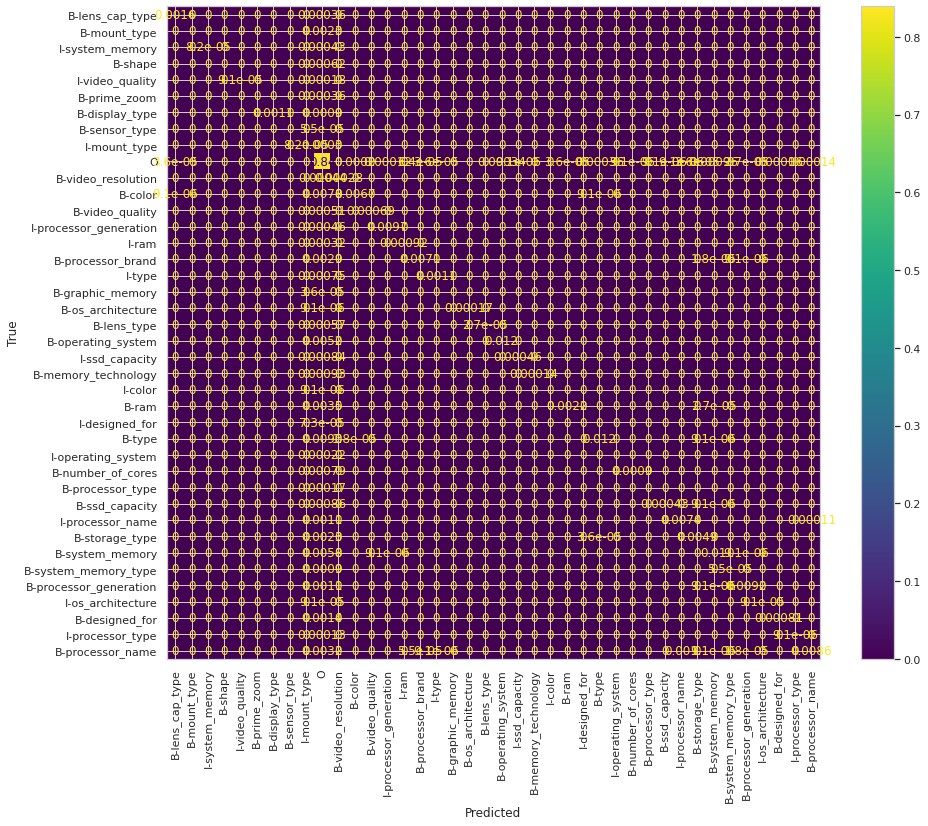

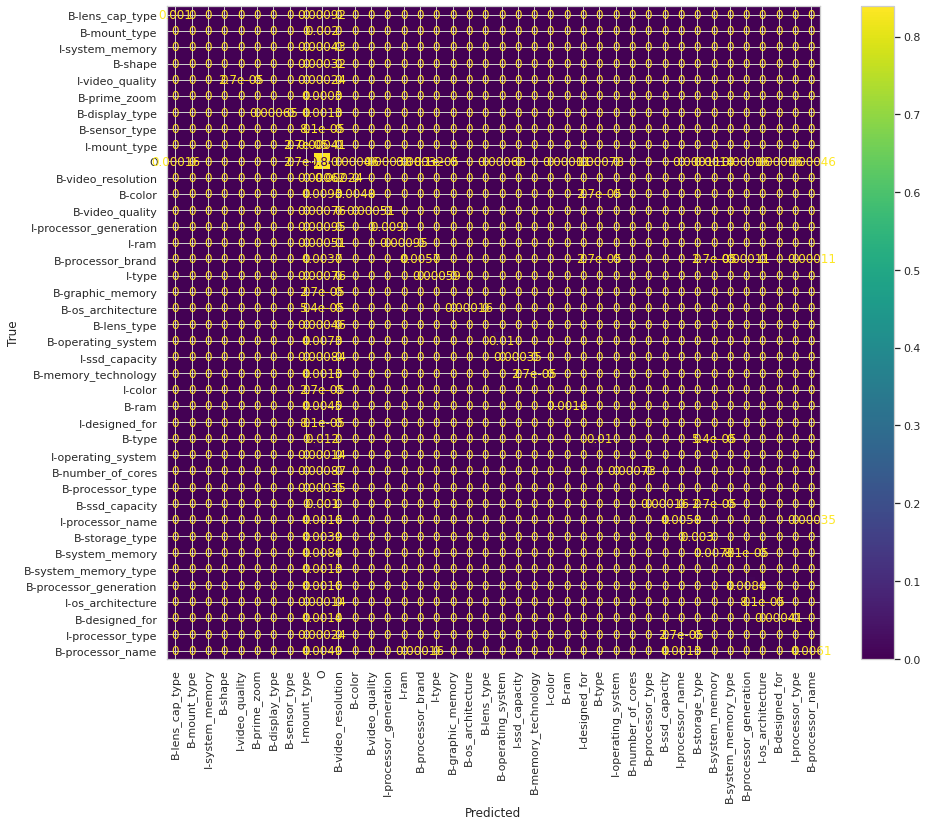

In [ ]:
# n_estimators -> number of trees in the "forest"
# max_depth -> maximum depth of each tree
# min_samples_leaf -> minimum number of samples required to be at a leaf node
param_grid = {"n_estimators": [10, 20, 50], "max_depth": [20, 30], "min_samples_leaf": [3]}
cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, n_jobs=-1, scoring="f1_macro", cv=4)
cv.fit(train_X, train_y)

classifier = cv.best_estimator_
print(cv.best_params_)
print(cv.best_score_)

train_predictions = classifier.predict(train_X)
test_predictions = classifier.predict(test_X)
print("Train Accuracy: ", round(100 * accuracy_score(train_y, train_predictions), 2))
print("Test Accuracy: ", round(100 * accuracy_score(test_y, test_predictions), 2))
print("Train F1: ", round(100 * f1_score(train_y, train_predictions, average="macro"), 2))
print("Test F1: ", round(100 * f1_score(test_y, test_predictions, average="macro"), 2))

def confusion_matrix_plot(true, model, X, label2class=label2class, class2label=class2label):
    true_classes = [label2class[value] for value in true]
    labels = list(label2class.values())
    plot_confusion_matrix(model, X, true, display_labels=labels, normalize='all', xticks_rotation="vertical")
    plt.xlabel("Predicted")
    plt.ylabel("True")


confusion_matrix_plot(train_y, classifier, train_X)

confusion_matrix_plot(test_y, classifier, test_X)

# free up some space
del train_X, test_X
del train_y, test_y
del word2vec
del classifier

### REVIEW RANDOM FOREST CLASSIFIER RESULTS
Conclusions from the results:
* As can be seen, the above 4-fold cross validation resulted in a macro-f1 score of 40%. 
* Confusion matrix and overall accuracy are about the same for both train and validation sets results at approx. ~92%.
* These optimistic results of above 90% are misleading in this case and not truly indicative of the model's performance because of the high class imbalance that we learned about in our exploratory analysis.
* As reflected on the confusion matrices and F1 scores and not to our surprise: this model mainly learned to predict the most common 'O' label while results are very low for the rest of the labels. 

### NER USING DEEP LEARNING ###


We try to employ an LSTM *network* to predict tags. 

## Data for deep Learning
We have N sentences and a fixed length of M, hence we need our tokens to be in an N*M array. Our labels should be in a similar array of size N*M because there is a tag for every token: <br>




In [ ]:
def get_data(data_generator):
    X = []
    y = []
    for pairs in data_generator:
        X.append([token for tag, token in pairs])  # todo
        y.append([tag for tag, token in pairs])
    return X, y


X_train, y_train = get_data(train_data_generator)
X_test, y_test = get_data(test_data_generator)

PADDING_TOKEN = "PAD"
UNKNOWN_TOKEN = "UNK"

# create a vocab to unique idx mapping and vice-versa
labels = list(chain.from_iterable(y_train))
idx2label = dict(enumerate(set(labels)))
label2idx = {value: key for key, value in idx2label.items()}

Since most of the tags are a minority, and we want the model to learn them well, we used class weight to assign weights to losses that will later be calculated during the model run:

In [ ]:
# calculating weight for class weights. These weights are used in the cross-entropy loss
count_label = dict(Counter(chain.from_iterable(y_train)))
inverse_counts = {key: 1. / value for key, value in count_label.items()}
sum_inverse = np.sum([count for _, count in inverse_counts.items()])
inverse_normalized = {key: value / sum_inverse for key, value in inverse_counts.items()}
weights = np.array([0.3 + inverse_normalized[idx2label[i]] for i in range(len(idx2label))])
weights /= np.sum(weights)

To make sure our sentences are of fixed length -> <br>
For sentences that are less in length than the set fixed length, we fill the remaining words with 'PAD' tokens in the end. <br>
For sentences greater in length than this fixed length, we truncate to the desired fixed length. <br>
We decided on the fixed length for a sentence based on our tokens distribution in which we see that nearly all the data can be found at number of tokens <= 50. <br> Beyond this point we have outliers that are truncated as mentioned. <br>
Let's assert all our data structures are aligned:

In [ ]:
# test that lenghths of tokens and labels are equal
def test1(X, y):
    for _x, _y in zip(X, y):
        assert len(_x) == len(_y)


test1(X_train, y_train)
test1(X_test, y_test)

MAX_LEN = 50
#truncate above 50 tokens
def trim(X, y, max_len=MAX_LEN):
    sequence = []
    for i in range(len(X)):
        if len(X[i])>=max_len:
            X[i] = X[i][:max_len]
            y[i] = y[i][:max_len]
            sequence.append(max_len)
        else:
            sequence.append(len(X[i]))
    return X, y, sequence

X_train, y_train, train_seq = trim(X_train, y_train, MAX_LEN)
X_test, y_test, test_seq = trim(X_test, y_test, MAX_LEN)

# test that sequence length is alinged with tokens and labels
def test2(X, y, sequence):
    assert len(X) == len(y)
    assert len(X) == len(sequence)
    for seq, tags in zip(X, y):
        assert len(tags) <= MAX_LEN
        assert len(seq) == len(tags)


test2(X_train, y_train, train_seq)
test2(X_test, y_test, test_seq)

inverse_normalized[PADDING_TOKEN] = 0



In addition, rare words that repeat 4 or less times are replaced with 'UNK' token. We also create a vocab to unique idx mapping and vice-versa:


In [ ]:
def replace_by_counts(tokens, max_count, replace_by):
    '''
        Replaces tokens with count<=max_counts by the token 'replace_by'
    '''
    counts = dict(Counter(tokens)).items()
    vocab = [token if count > max_count else replace_by for token, count in counts]
    return list(set(vocab))

tokens = list(chain.from_iterable(X_train))
vocab = replace_by_counts(tokens, 4, UNKNOWN_TOKEN)
vocab.append(PADDING_TOKEN)
idx2word = dict(enumerate(set(vocab)))
word2idx = {value: key for key, value in idx2word.items()}

labels = list(chain.from_iterable(y_train))
labels.append(PADDING_TOKEN)
idx2label = dict(enumerate(set(labels)))
label2idx = {value: key for key, value in idx2label.items()}
weights = np.array([0.3 + inverse_normalized[idx2label[i]] for i in range(len(idx2label))])
weights /= np.sum(weights)


replace tokens by their indices from the dictionary. Same for labels


In [ ]:
def unk_map(x, token2idx, unk):
    '''
    Replace tokens by unk token idx if they are not in the vocabulary
    '''
    idx = []
    for word in x:
        if word not in token2idx.keys():
            idx.append(unk)
        else:
            idx.append(token2idx[word])
    return idx


unk_idx = word2idx["UNK"]

X_train = list(map(lambda x: unk_map(x, word2idx, unk_idx), X_train))
y_train = list(map(lambda x: [label2idx[word] for word in x], y_train))

X_test = list(map(lambda x: unk_map(x, word2idx, unk_idx), X_test))
y_test = list(map(lambda x: [label2idx[word] for word in x], y_test))


Creating pytorch dataset for iteration and generating batches:


In [ ]:
class NERDataset(Dataset):
    def __init__(self, X, y, sequence):
        self.X = X
        self.y = y
        self.seq = sequence

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.seq[idx]

Now we pad sentences shorter than 50 tokens:

In [ ]:

def pad(X, Y, seq, pad_idx, pad_label, max_len):
    '''
    add pad_idx to tokens and pad_label to labels is correspinding PAD tokens
    '''
    X_padd = []
    y_padd = []
    for x, y in zip(X, Y):
        x_len = max_len - len(x)
        X_padd.append(x + [pad_idx] * x_len)
        y_padd.append(y + [pad_label] * x_len)
    X_padd = torch.LongTensor(X_padd)
    y_padd = torch.LongTensor(y_padd)
    seq = torch.LongTensor(seq)
    return X_padd, y_padd, seq


X_train, y_train, train_seq = pad(X_train, y_train, train_seq, word2idx["PAD"], label2idx["PAD"], MAX_LEN)

X_test, y_test, test_seq = pad(X_test, y_test, test_seq, word2idx["PAD"], label2idx["PAD"], MAX_LEN)


Inserting our train and test sets into pytorch dataset structure and for batch creation we use pytorch DataLoader:

In [ ]:
train_dataset = NERDataset(X_train, y_train, train_seq)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = NERDataset(X_test, y_test, test_seq)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## MODEL BUILDING - BIDIRECTIONAL LSTM ##

In [ ]:
#define our own NERLstm class
class NERLstm(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, padding_idx, max_len, num_layers):
        super(NERLstm, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2 * hidden_dim, tagset_size)
        self.padding_idx = padding_idx
        self.max_len = max_len
        self.tagset_size = tagset_size
        self.padding_idx = padding_idx

    def forward(self, X, seq):
        embeddings = self.word_embeddings(X)
        packed_input = pack_padded_sequence(embeddings, seq, batch_first=True, enforce_sorted=False)
        packed_output, (ht, ct) = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = self.linear(output)
        return output

In [ ]:
# Calculate loss function that is not taking PAD loss into account by masking it from the loss results.
def loss(true, pred, pad_idx, target_size, max_len, weights=None, device="cpu"):
    batch_size = pred.shape[0]
    max_batch = pred.shape[1]
    weights = torch.Tensor(weights)
    weights = weights.to(device)
    loss_fn = nn.CrossEntropyLoss(reduction='none', weight=weights)
    pred = pred[:, :max_batch, :]
    true = true[:, :max_batch].contiguous()
    true = true.view(-1)
    pred = pred.view(-1, target_size)
    loss = loss_fn(pred, true)
    mask = true != pad_idx
    mask = mask.view(-1).type(torch.FloatTensor).to(device)
    mask /= mask.shape[0]
    return torch.dot(mask, loss) / torch.sum(mask)

# given a sentence, predict the labels of tokens
def generate_predictions(model, X, seq, device="cuda"):
    X = X.to(device)
    seq = seq.to(device)
    pred = model(X, seq)
    pred_labels = torch.argmax(pred, 2)
    # print(pred_labels.view(0))
    pred_labels = pred_labels.view(-1)
    return pred_labels

# correct true labels divided by total number of generated predictions
def accuracy(model, X, seq, y_true, pad_idx, device):
    y_true = y_true.view(-1)
    y_pred = generate_predictions(model, X, seq, device)
    mask = y_true != pad_idx
    mask = mask.type(torch.FloatTensor)
    matches = y_pred == y_true
    matches = matches.type(torch.FloatTensor)
    correct = torch.dot(matches, mask)
    total = len(y_pred)
    accuracy = correct.item() / total
    return accuracy

## TRAINING LOOP

As mentioned before, we need to NOT take into account PAD predictions in the metric calculation. We made sure to not include it in the loss function calculation. However, when making inferences on test data, we generate predictions for PAD token but we don't take it into account while computing the metric.


Here we define set of hyper-parameters according to standard values observed in other NER use cases similar to ours:

In [ ]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
VOCAB_SIZE = len(word2idx)
TAGSET_SIZE = len(idx2label)
BATCH_SIZE = 128
LEARNING_RATE = 10e-3
EPOCHS = 10 
NUM_LAYERS = 3

config = {
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'vocab_size': VOCAB_SIZE,
    'tagset_size': TAGSET_SIZE,
    'padding_idx': word2idx["PAD"],
    'max_len': MAX_LEN,
    'num_layers': NUM_LAYERS
}


Define an optimizer that will hold the current state and will update the parameters based on the computed gradients:

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = NERLstm(**config)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

There is a  big jump in the metric that is achieved by fine-tuning the starting learning-rate to 10e-3. Making the LSTM bidirectional also provided a substantial boost. <BR>
In each epoch, we calculate the loss derived from the gaps between the predictions made by our model and the actual labels. The BiLSTM network is diminishing the loss through adjusting the weights.


In [ ]:
train_loss = []
test_loss = []
test_accuracy = []
train_accuracy = []

for i in range(EPOCHS):
    epoch_loss = 0
    model = model.train()
    LEARNING_RATE *= 0.8
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for j, (X, y, sequence) in enumerate(train_loader):
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        sequence = sequence.to(device)
        pred = model(X, sequence)
        loss_value = loss(y, pred, config['padding_idx'], config['tagset_size'], config["max_len"], weights=weights,
                          device=device)
        loss_value.backward()
        epoch_loss += loss_value.item()
        optimizer.step()
        del X, y, sequence
        torch.cuda.empty_cache()

    model = model.eval()

    train_loss.append(round(epoch_loss, 3))

    X_test = X_test.to(device)
    y_test = y_test.to(device)
    test_seq = test_seq.to(device)

    y_pred = model(X_test, test_seq)
    test_epoch_loss = loss(y_test, y_pred, config['padding_idx'], config['tagset_size'], config["max_len"], weights,
                           device)
    test_epoch_loss = round(test_epoch_loss.item(), 3)
    test_loss.append(test_epoch_loss)

    test_epoch_acc = round(accuracy(model, X_test, test_seq, y_test, config["padding_idx"], device), 3)
    test_accuracy.append(test_epoch_acc)

    print("-----------Epoch: {}-----------".format(i + 1))
    print("Loss:\ntrain:{0}\ntest:{1}\n".format(round(epoch_loss, 2), test_epoch_loss))
    print("Accuracy:\ntest:{0}\n".format(test_epoch_acc))


-----------Epoch: 1-----------
Loss:
train:4.88
test:0.02

Accuracy:
test:0.987

-----------Epoch: 2-----------
Loss:
train:1.64
test:0.006

Accuracy:
test:0.991

-----------Epoch: 3-----------
Loss:
train:0.51
test:0.002

Accuracy:
test:0.992

-----------Epoch: 4-----------
Loss:
train:0.18
test:0.001

Accuracy:
test:0.993

-----------Epoch: 5-----------
Loss:
train:0.08
test:0.001

Accuracy:
test:0.993

-----------Epoch: 6-----------
Loss:
train:0.04
test:0.001

Accuracy:
test:0.994

-----------Epoch: 7-----------
Loss:
train:0.02
test:0.001

Accuracy:
test:0.994

-----------Epoch: 8-----------
Loss:
train:0.01
test:0.001

Accuracy:
test:0.995

-----------Epoch: 9-----------
Loss:
train:0.01
test:0.001

Accuracy:
test:0.995

-----------Epoch: 10-----------
Loss:
train:0.01
test:0.001

Accuracy:
test:0.995



Here we see the increase in accuracy with each epoch:

Text(0, 0.5, 'Accuracy')

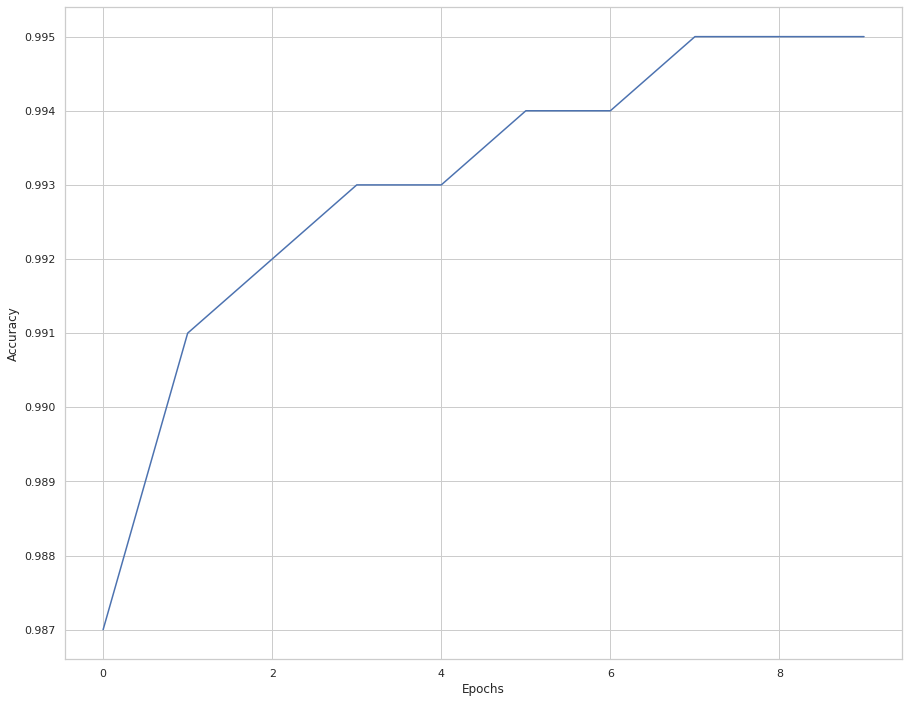

In [ ]:
plt.plot(test_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Here we see the loss decrease for the test set:

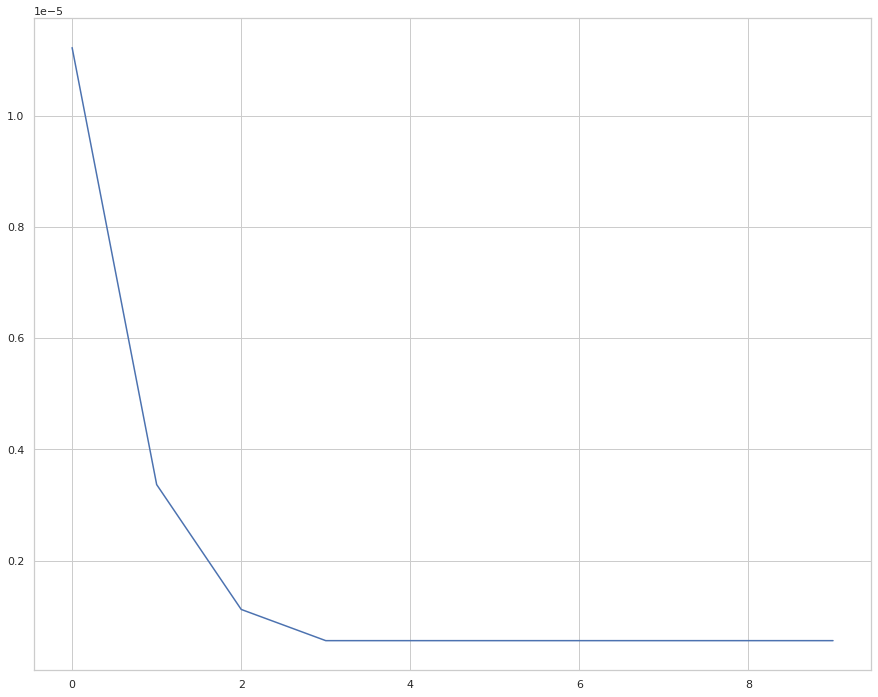

In [ ]:
plt.plot(np.array(test_loss) / len(X_test))

Here we see the loss decrease for the train set:




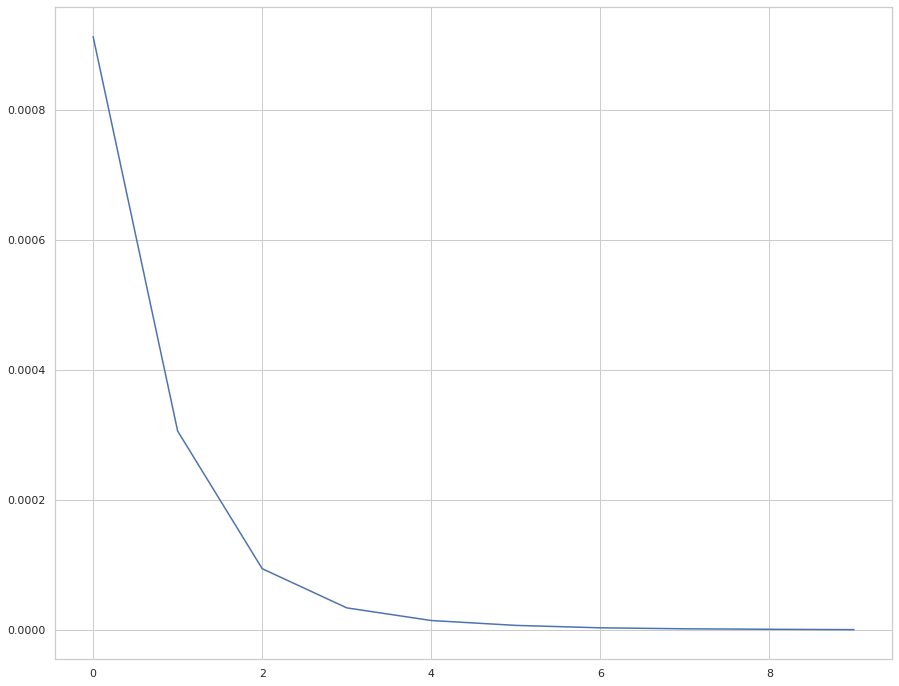

In [ ]:
plt.plot(np.array(train_loss) / len(X_train))

Here we calculate the F1 scores for each of the labels:

In [ ]:
def F1_scores(y_true, y_pred, idx, pad_idx):
    y_pred = torch.argmax(y_pred, 2)
    y_true = y_true.to("cpu").type(torch.LongTensor).numpy().reshape(-1)
    y_pred = y_pred.to("cpu").type(torch.LongTensor).numpy().reshape(-1)

    tp = 0
    tn = 0
    fp = 0
    fn = 0
    p = 0
    n = 0
    for i, true in enumerate(y_true):
        if true != pad_idx:
            pred = y_pred[i]
            if true == idx:
                p += 1
                if pred == idx:
                    tp += 1
                else:
                    fn += 1
            else:
                n += 1
                if pred == idx:
                    fp += 1
                else:
                    tn += 1

    precision = tp / (tp + fp + 0.0001)
    recall = tp / (tp + fn + 0.0001)
    f1 = 2 * precision * recall / (precision + recall + 0.0001)

    return round(f1, 3), round(precision, 3), round(recall, 3)

data=[]
total = 0
for tag, idx in label2idx.items():
    f1, prec, rec = F1_scores(y_test, y_pred, label2idx[tag], label2idx["PAD"])
    print(tag + " stats: " + "precision: ", prec, " recall: ", rec, " F1: ", f1)
    data.append((tag,    prec,    rec,    f1))
    total += f1

print("------ Average: {} ------".format(total / len(label2idx)))

scores_df = pd.DataFrame(columns=['tag', 'precision', 'recall', 'F1',],data=data)
filename=os.path.join(path_name,'scores_df.csv')
scores_df.to_csv(filename, encoding='utf-8', index=False)

B-lens_cap_type stats: precision:  1.0  recall:  0.986  F1:  0.993
B-mount_type stats: precision:  0.947  recall:  0.959  F1:  0.953
I-system_memory stats: precision:  0.75  recall:  0.75  F1:  0.75
B-shape stats: precision:  0.846  recall:  0.917  F1:  0.88
I-video_quality stats: precision:  1.0  recall:  0.9  F1:  0.947
B-prime_zoom stats: precision:  0.818  recall:  0.818  F1:  0.818
B-display_type stats: precision:  0.986  recall:  0.945  F1:  0.965
B-sensor_type stats: precision:  1.0  recall:  1.0  F1:  1.0
I-mount_type stats: precision:  1.0  recall:  0.875  F1:  0.933
O stats: precision:  0.993  recall:  0.993  F1:  0.993
B-video_resolution stats: precision:  0.939  recall:  0.969  F1:  0.954
B-color stats: precision:  0.97  recall:  0.977  F1:  0.973
B-video_quality stats: precision:  0.953  recall:  0.872  F1:  0.911
I-processor_generation stats: precision:  0.997  recall:  0.995  F1:  0.996
I-ram stats: precision:  0.979  recall:  0.852  F1:  0.911
B-processor_brand stats: p

In absolute numbers, these are the sorted counts of incorrect predictions:



In [ ]:
# analysis
def analyze(y_pred, y_true, X_test):
    y_pred = torch.argmax(y_pred, 2)
    y_true = y_true.to("cpu").type(torch.LongTensor).numpy().reshape(-1)
    y_pred = y_pred.to("cpu").type(torch.LongTensor).numpy().reshape(-1)
    X_test = X_test.to("cpu").type(torch.LongTensor).numpy().reshape(-1)
    where_incorrect = y_true != y_pred
    incorrect_idxes = np.where(where_incorrect == 1)[0]
    incorrect_tokens = X_test[incorrect_idxes]
    return dict(Counter(incorrect_tokens))


incorrect_dict = analyze(y_pred, y_test, X_test)
incorrect_dict = sorted(incorrect_dict.items(), key=lambda x: x[1], reverse=True)
for idx, count in incorrect_dict[:20]:
    print(idx2word[idx], " ----> ", count)

intel  ---->  36
laptop  ---->  31
core  ---->  24
HD  ---->  21
8gb  ---->  20
GB  ---->  19
4gb  ---->  18
ssd  ---->  17
black  ---->  14
canon  ---->  14
game  ---->  13
window  ---->  12
smart  ---->  12
16gb  ---->  12
32gb  ---->  8
UNK  ---->  8
mini  ---->  8
hdd  ---->  8
processor  ---->  7
android  ---->  6


As can be seen, there are very few cases of incorrect predictions compared to the total number of tokens in the dataset.

Now we will apply our recent LSTM NER model on real life products from Amazon to see how well it performs: 

In [ ]:
def predict_tags(sentence, model=model, word2idx=word2idx,
                 idx2word=idx2word, label2idx=label2idx, idx2label=idx2label):
    tokens = sentence.lower().split()
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    length = len(tokens)
    tokens_idx = []
    for token in stemmed_tokens:
        if token not in word2idx.keys():
            tokens_idx.append(word2idx["UNK"])
        else:
            tokens_idx.append(word2idx[token])

    tokens_idx = torch.LongTensor(tokens_idx).unsqueeze(0)
    sequence = torch.LongTensor([length])
    predictions = generate_predictions(model, tokens_idx, sequence)
    for token, label in zip(tokens, predictions):
        print(token, " ----> ", idx2label[label.item()])

In [ ]:
print(str(predict_tags('HP 14 Ultra Thin and Light Laptop 10th Gen i5 1035G1 8GB 512GB SSD Windows 10 Home MS Office 2019, 14s-dq1090tu')) + '\n')
print(str(predict_tags('Canon EOS 1500D 24.1 Digital SLR Camera (Black) with EF S18-55 is II Lens, 16GB Card and Carry Case')) + '\n')
print(str(predict_tags('Lenovo Ideapad Slim i3 10th Gen Intel Core i5 15.6 inch FHD Thin and Light Laptop 8GB 1TB Windows 10 Grey 1.85Kg, 81WE007UIN')) + '\n')
print(str(predict_tags('HP 15q ds0049TU 15.6-inch Laptop 8th Gen i3-8130U 8GB 256GB SSD Windows 10 Home MS Office 2019 Integrated Graphics, Jet Black')) + '\n')

hp  ---->  O
14  ---->  O
ultra  ---->  O
thin  ---->  O
and  ---->  O
light  ---->  O
laptop  ---->  O
10th  ---->  B-processor_generation
gen  ---->  I-processor_generation
i5  ---->  B-processor_name
1035g1  ---->  O
8gb  ---->  B-system_memory
512gb  ---->  O
ssd  ---->  O
windows  ---->  B-operating_system
10  ---->  O
home  ---->  O
ms  ---->  O
office  ---->  B-type
2019,  ---->  O
14s-dq1090tu  ---->  O
None

canon  ---->  O
eos  ---->  O
1500d  ---->  O
24.1  ---->  O
digital  ---->  B-display_type
slr  ---->  O
camera  ---->  O
(black)  ---->  O
with  ---->  O
ef  ---->  O
s18-55  ---->  O
is  ---->  O
ii  ---->  O
lens,  ---->  O
16gb  ---->  O
card  ---->  O
and  ---->  O
carry  ---->  O
case  ---->  B-type
None

lenovo  ---->  O
ideapad  ---->  O
slim  ---->  O
i3  ---->  B-processor_name
10th  ---->  B-processor_generation
gen  ---->  I-processor_generation
intel  ---->  B-processor_name
core  ---->  I-processor_name
i5  ---->  I-processor_name
15.6  ---->  O
inch  ----> 

## REVIEW BILSTM CLASSIFIER RESULTS ##
For most of the labels that have a reasonable amount of instances in our dataset, we see good scores. The average macro-f1 score is ~87% with weighted f1 score of ~98%. When we actually validate tags prediction on randomly selected Amazon products we get the expected labels (within the training scope).Expectedly, increasing the number of epochs from 3 to 10 added ~10% to the macro-f1 score. Important to note that the model was able to predict according to the right context i.e. the right category, for example: for a laptop, attribute B-system_memory was identified but not for a camera.

## SUMMARY ##
 
During the project we used 4 models in order to achieve our goal of labeling product attributes in product names. As we dealt with actual products data we started experimenting with out-of-the-box spacy model which was based on Recurrent Neural Networks. This attempt brought poor results, perhaps due to lack of appropriate adjustments of the parameters needed for this model. We did not attempt to improve it because we knew that we will be able to direct our efforts in more suitable approaches to our use case.

Next we moved on to try the Conditional Random Fields model on the products data. It showed great improvement and was very versatile in its features. Since we used preceding and following words, POS tags etc. 
CRF gave us good results for a classical ML model: macro-F1= ~ 84% and weighted-F1= 97%.
Then we tried to use the Random Forest classification with use of word embeddings to represent tokens. Like with the spacy model, we also were disappointed with the results (F1=~37%).
 
Finally we moved to the state-of-the-art approach, Long Short-Term Memory artificial recurrent neural network. In this part we leverage the power of neural networks by specifically adjusting our model’s parameters (e.g. the weights for each label) to reach a high correlation with our data. Such steps have greatly helped our loss function to accurately return the loss per label. We reached the hughes scores using this model: macro-F1= ~ 87%,
weighted-F1=~ 98%.
 
We think that the product of our effort can be used extensively in the ecommerce world. We hope to incorporate it into our existing systems while improving and adjusting to real world needs.



In [ ]:
fp = '/content/drive/My Drive/Colab/Data sets/train_set_all_cms.txt'
!jupyter nbconvert --to html "/content/drive/My Drive/Colab Notebooks/NER_models_final_notebook.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/NER_models_final_notebook.ipynb to html
[NbConvertApp] Writing 1837471 bytes to /content/drive/My Drive/Colab Notebooks/NER_models_final_notebook.html
